/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (50000,)


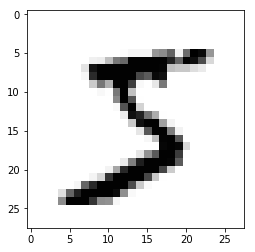

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
def one_hot(y):
    """
    Inputs:
    - y: lD vector of (n_sample,)
    
    Returns:
    - y_one_hot: one hot encoding y
    """
    n_class = len(np.unique(y))
    
    return np.eye(n_class)[y.reshape(-1)]

In [3]:
def next_batch(data, batch_size=32, shuffle=True):
    """
    Inputs:
    - data: tuple of (X, y)
    - batch_size: size of batch
    - shuffled: shuffle data
    
    Return:
    - batch sampled data of (X, y)
    """
    
    X, y = data
    assert X.shape[0] == y.shape[0]
    
    n_sample = X.shape[0]
    n_batch = n_sample // batch_size
    n_batch = n_batch + 1 if (n_sample % n_batch) != 0 else n_batch 
    idx = np.arange(n_sample)
    if shuffle:
        np.random.shuffle(idx)
        
    for b in range(n_batch):
        start, end = b * batch_size, (b + 1) * batch_size
        if end > n_sample:
            sample_idx = idx[start:]
        else:
            sample_idx = idx[start:end]

        yield X[sample_idx, :], y[sample_idx, :]

In [4]:
def init_weights(layers):
    """
    Inputs:
    - layers: list of (n_inputs, n_outputs)
    
    Return:
    - weights: list of layer weight (W, b)
    """
    
    def xavier_initializer(n_inputs, n_outputs):
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform([n_inputs, n_outputs], -init_range, init_range)
   
    weights = []
    for n_inputs, n_outputs in layers:
        W = tf.Variable(xavier_initializer(n_inputs, n_outputs))
        b = tf.Variable(tf.zeros(n_outputs))
        weights.append((W, b))

    return weights   

In [5]:
def foward(input_X, input_y, weights):
    """
    Inputs:
    - input_X: tensor (None, n_features)
    - input_y: tensor (None, n_class)
    - weights: list of layer weights (W, b)
    
    Return:
    - logits: model logits
    """
    
    A = input_X
    for idx, (W, b) in enumerate(weights):
        Z = tf.matmul(A, W) + b
        
        # last layer
        if idx == (len(weights) - 1):
            A = tf.nn.sigmoid(Z)
        else:
            A = tf.nn.relu(Z)
            
    logits = A
    
    return logits   

## Data preprocess

In [6]:
# Flatten data to 1D vector
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# one hot encoding
y_train_en = one_hot(y_train)
y_test_en = one_hot(y_test)

## Build Model

#### Weights initialization

In [7]:
n_features = X_train.shape[1]
n_class = y_train_en.shape[1]

hidden_dims = [
    (n_features, 256),
    (256, 128),
    (128, 64),
    (64, n_class)
]

weights = init_weights(hidden_dims)

#### Build tensorflow op

In [8]:
input_X = tf.placeholder(tf.float32, shape=(None, n_features))
input_y = tf.placeholder(tf.float32, shape=(None, n_class))

logits = foward(input_X, input_y, weights)

predict = tf.nn.softmax(logits)
acc = tf.equal(tf.argmax(predict, axis=-1), tf.argmax(input_y, axis=-1))
acc = tf.reduce_mean(tf.cast(acc, tf.float32))

loss = input_y * tf.log(predict) + (1. - input_y) * tf.log(1. - predict)
loss = -tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
#loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y)
#loss = tf.reduce_mean(loss)

train = tf.train.AdamOptimizer().minimize(loss)

#### Parameters

In [9]:
epochs = 30
batch_size = 128

In [10]:
train_loss_hist = np.zeros(epochs)
train_acc_hist = np.zeros(epochs)

test_loss_hist = np.zeros(epochs)
test_acc_hist = np.zeros(epochs)

data = (X_train, y_train_en)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):

        train_batch_loss = []
        train_batch_acc = []
        
        for X_batch, y_batch in next_batch(data, batch_size=batch_size):
            _, train_loss, train_acc = sess.run([train, loss, acc], 
                                     feed_dict = {input_X: X_batch, input_y: y_batch})
            train_batch_loss.append(train_loss)
            train_batch_acc.append(train_acc)
            
        train_loss_hist[e] = np.mean(train_batch_loss)
        train_acc_hist[e] = np.mean(train_batch_acc)
        
        test_loss, test_acc = sess.run([loss, acc], 
                                     feed_dict = {input_X: X_test, input_y: y_test_en})
        test_loss_hist[e] = test_loss
        test_acc_hist[e] = test_acc
        
        if e % 5 == 4:
            print('[{:3d}/{:3d}] | Train loss: {:4.4f} acc: {:4.2f}% | Test loss: {:6.4f} acc: {:4.2f}%'.format( \
                e + 1, epochs, \
                train_loss_hist[e], train_acc_hist[e] * 100,
                test_loss_hist[e], test_acc_hist[e] * 100))

[  5/ 30] | Train loss: 2.2872 acc: 97.80% | Test loss: 2.2916 acc: 97.34%
[ 10/ 30] | Train loss: 2.2759 acc: 98.86% | Test loss: 2.2888 acc: 97.70%
[ 15/ 30] | Train loss: 2.2724 acc: 99.22% | Test loss: 2.2886 acc: 97.48%
[ 20/ 30] | Train loss: 2.2706 acc: 99.39% | Test loss: 2.2868 acc: 97.71%
[ 25/ 30] | Train loss: 2.2701 acc: 99.43% | Test loss: 2.2885 acc: 97.71%
[ 30/ 30] | Train loss: 2.2682 acc: 99.61% | Test loss: 2.2857 acc: 98.01%


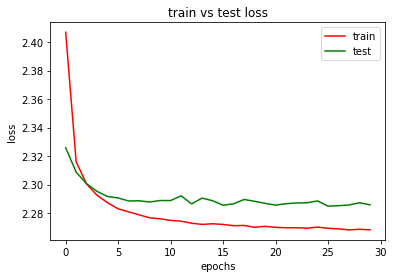

In [11]:
plt.title('train vs test loss')
plt.plot(train_loss_hist, c='r', label='train')
plt.plot(test_loss_hist, c='g', label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()